### Step 1: Install Required Libraries ###

In [1]:
!python3 -m pip install --upgrade pip
!source .venv/bin/activate
!pip install numpy pandas matplotlib seaborn tensorflow keras xgboost scikit-learn fastapi

### Step 2: Load and Prepare Data ###

Let's assume we have a dataset (cash_flow_data.csv) with the following columns:

 - date: Daily timestamps
 - sales: Revenue from sales
 - expenses: Daily expenses
 - cash_inflow: Cash received
 - cash_outflow: Cash spent
 - net_cash_flow: cash_inflow - cash_outflow (target variable)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/home/jefferyp/Documents/projects/Cashflow_Forecasting/cashflow_2024.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Fill missing values
# df.fillna(method="ffill", inplace=True)
df.ffill(inplace=True)

# Create lag features (past cash flow as features)
for lag in range(1, 8):  # 7-day lag
    df[f"net_cash_flow_lag_{lag}"] = df["net_cash_flow"].shift(lag)

# Drop missing values (due to lagging)
df.dropna(inplace=True)
del df['Activity']

# Check dataset
df.head()
# df.info()

,cash_inflow,cash_outflow,net_cash_flow,gross_sales,cogs,net_cash_flow_lag_1,net_cash_flow_lag_2,net_cash_flow_lag_3,net_cash_flow_lag_4,net_cash_flow_lag_5,net_cash_flow_lag_6,net_cash_flow_lag_7
Date,,,,,,,,,,,,
2024-01-01,13535.04,0.00,13535.04,49.00,18.60,13535.04,-39.00,1306.95,209.00,-39.00,1136.95,-1345.95
2024-01-01,13496.04,0.00,13496.04,49.00,18.60,13535.04,13535.04,-39.00,1306.95,209.00,-39.00,1136.95
2024-01-02,0.00,-244.85,-244.85,418.18,40.08,13496.04,13535.04,13535.04,-39.00,1306.95,209.00,-39.00
2024-01-02,938.20,0.00,938.20,418.18,40.08,-244.85,13496.04,13535.04,13535.04,-39.00,1306.95,209.00
2024-01-02,453.50,0.00,453.50,418.18,40.08,938.20,-244.85,13496.04,13535.04,13535.04,-39.00,1306.95


### Step 3: Feature Engineering ###

In [3]:
from sklearn.preprocessing import StandardScaler

# Add time-based features
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month

# Scale numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# Split into training and testing
train_size = int(len(df) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

# Define target variable
X_train, y_train = train.drop(columns=["net_cash_flow"]), train["net_cash_flow"]
X_test, y_test = test.drop(columns=["net_cash_flow"]), test["net_cash_flow"]


### Step 4: Train an XGBoost Model ###

XGBoost MAE: 0.07415677575725671


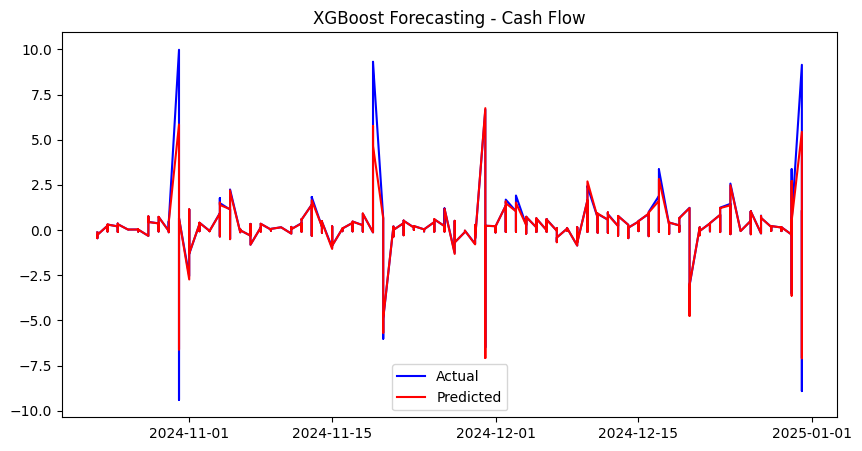

In [4]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_test, label="Actual", color="blue")
plt.plot(test.index, y_pred_xgb, label="Predicted", color="red")
plt.legend()
plt.title("XGBoost Forecasting - Cash Flow")
plt.show()


### Step 5: Train an LSTM Model (Deep Learning) ###

2025-03-06 21:25:08.441595: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 21:25:08.445598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 21:25:08.456107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741321508.477564  263877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741321508.483743  263877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 21:25:08.505087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/20


2025-03-06 21:25:11.119758: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jefferyp/Documents/projects/Cashflow_Forecasting/.venv/lib64/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1078 - val_loss: 0.3540
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0674 - val_loss: 0.2637
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0681 - val_loss: 0.2826
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0676 - val_loss: 0.2962
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0647 - val_loss: 0.2625
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0673 - val_loss: 0.3002
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0663 - val_loss: 0.2241
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0655 - val_loss: 0.3166
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0651 - val_loss: 0.2591
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0676 - val_loss: 0.2732
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0645 - val_loss: 0.2422
Epoch 12/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0

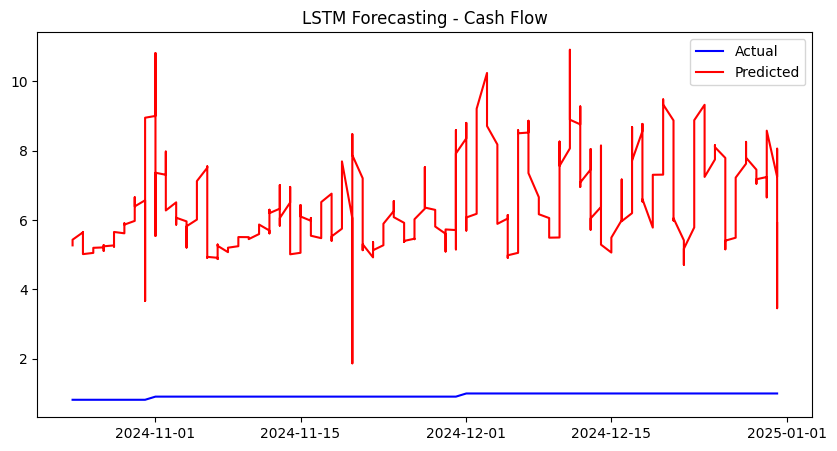

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Reshape for LSTM input
scaler_lstm = MinMaxScaler()
scaled_lstm = scaler_lstm.fit_transform(df)

# Create sequences for LSTM (past 7 days → next day prediction)
def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :-1])  # All columns except target
        y.append(data[i+n_steps, -1])  # Target column
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_lstm)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Define LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predictions
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale predictions back to original values
y_pred_lstm = scaler_lstm.inverse_transform(np.concatenate((X_test_lstm[:, -1, :], y_pred_lstm), axis=1))[:, -1]

# Evaluate LSTM
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"LSTM MAE: {mae_lstm}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index[-len(y_pred_lstm):], y_test_lstm, label="Actual", color="blue")
plt.plot(test.index[-len(y_pred_lstm):], y_pred_lstm, label="Predicted", color="red")
plt.legend()
plt.title("LSTM Forecasting - Cash Flow")
plt.show()


### Step 6: Deploy the Model ###

Use Flask or FastAPI to expose the model as an API for integration into POS systems.

In [12]:
from fastapi import FastAPI
import numpy as np

app = FastAPI()

@app.get("/predict_cash_flow/")
def predict_cash_flow(features: str):
    features_array = np.array([float(x) for x in features.split(",")]).reshape(1, -1)
    prediction = model_xgb.predict(features_array)[0]
    return {"predicted_cash_flow": float(prediction)}


### Final Thoughts ###

1. Which model to use?
    - XGBoost: Faster, interpretable, suitable for structured financial data.
    - LSTM: Better for sequential dependencies but requires more data.

2. Next Steps
    - Integrate real-time data (API from POS/ERP).
    - Automate model retraining using cloud platforms (AWS Lambda, Google Cloud Functions).
    - Implement anomaly detection for unusual cash flow patterns.

Would you like help with deployment on AWS or GCP? 🚀